# Predicting Heart Disease - A Classification Problem for Cleveland Patients

##### Group 19: Matthew Campbell, Andy Li, Fang Peian, Pedro Vieira Sodre

### A) Introduction:

All over the world, developed nations provide a comfortable and safe quality of life. However, this has led their populations to trend towards more sedentary, high caloric lifestyles that have been proven to play a major role in the increased incidence of heart disease (Ornish et al., 1990). It is one of the leading causes of mortality in the Western world, and therefore, factors that might contribute to this diagnosis are under constant study.

In this project, our team will analyze various factors that are believed to play some role in the development of heart disease. We will use a heart disease data set from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) to accomplish this. We will be analyzing the processed data from Cleveland consisting of 14 different variables collected from patients entering the hospital and complaining of their chest pain. To begin we will visualize any potential trends between age, heart rate, cholesterol, and blood pressure. Our question will be:
    
    In Cleveland, are there predictors that nicely segregate patients with heart disease from patients without heart disease. And, can we use these factors to accurately predict whether or not new patients are likely to have advanced heart disease?

### B) Preliminary exploratory data analysis:

For this project we will need the following three library packages
* tidyverse - to collect, tidy and wrangle our dataset
* repr - for plotting our visualizations
* tidymodels - to streamline our Knn calculations
* cowplot - to aid in visualizations

In [11]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

Next, we will download our dataset from the web.

In [12]:
cleveland_heart_data <- read_csv(file = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
head(cleveland_heart_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


We have successfully downloaded our dataset, but we must now tidy it. We have included a list describing all the extra predictors in an appendix at the end of this proposal.

In [13]:
labelled_heart_data <- cleveland_heart_data %>%
    rename(age = "X1",
            sex = "X2",
            chest_pain_type = "X3",
            resting_bp = "X4",
            cholesterol = "X5",
            fasting_bs = "X6",
            resting_ecg = "X7",
            heartrate_max = "X8",
            exang = "X9",
            oldpeak = "X10",
            slope = "X11",
            ca = "X12",
            thal = "X13",
            disease_status = "X14") %>%
    select(age, 
           resting_bp, 
           disease_status, 
           heartrate_max) %>%
    mutate(heartrate_max = as.integer(heartrate_max), 
           resting_bp = as.integer(resting_bp)) %>%
    filter(resting_bp != "?") %>%
    arrange(age)

head(clean_heart_data)

age,resting_bp,disease_status,heartrate_max
<dbl>,<int>,<dbl>,<int>
29,130,0,202
34,118,0,174
34,118,0,192
35,138,0,182
35,120,1,130
35,126,1,156


Our disease status variable is a little strange. We need to re-classify the column so:
* 0 = no heart disease
* 1 = heart disease present

In [14]:

clean_heart_data["disease_status"][clean_heart_data["disease_status"] == 1] <- 5
clean_heart_data["disease_status"][clean_heart_data["disease_status"] == 2] <- 5
clean_heart_data["disease_status"][clean_heart_data["disease_status"] == 3] <- 5
clean_heart_data["disease_status"][clean_heart_data["disease_status"] == 4] <- 5
clean_heart_data["disease_status"][clean_heart_data["disease_status"] == 5] <- 1

clean_heart_data <- clean_heart_data %>%
    mutate(disease_status = as_factor(disease_status)) %>%
    print(clean_heart_data)

# A tibble: 303 x 4
     age resting_bp disease_status heartrate_max
   <dbl>      <int> <fct>                  <int>
 1    29        130 0                        202
 2    34        118 0                        174
 3    34        118 0                        192
 4    35        138 0                        182
 5    35        120 1                        130
 6    35        126 1                        156
 7    35        122 0                        174
 8    37        130 0                        187
 9    37        120 0                        170
10    38        120 1                        182
# … with 293 more rows


Finally, we must set a seed to guarantee reproducibility and then split our data into training and testing datasets.

In [15]:
set.seed(999)

heart_split <- initial_split(clean_heart_data, prop = .75, strata = disease_status)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

print(heart_train, 1:228) 

# A tibble: 228 x 4
     age resting_bp disease_status heartrate_max
   <dbl>      <int> <fct>                  <int>
 1    29        130 0                        202
 2    34        118 0                        192
 3    35        138 0                        182
 4    35        120 1                        130
 5    35        122 0                        174
 6    37        130 0                        187
 7    37        120 0                        170
 8    38        120 1                        182
 9    38        138 0                        173
10    39        138 0                        152
# … with 218 more rows


We have our training data! Now we will summarize and visualize some important information about our predictors.

In [16]:
disease_count <- heart_train %>%
    group_by(disease_status) %>%
    summarize(n = n())
disease_count

predictor_means <- heart_train %>%
    select(-disease_status) %>%
    summarize(across(age:heartrate_max, mean, na.rm = TRUE))
predictor_means

`summarise()` ungrouping output (override with `.groups` argument)



disease_status,n
<fct>,<int>
0,123
1,105


age,resting_bp,heartrate_max
<dbl>,<dbl>,<dbl>
54.26316,132.25,150.6623


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


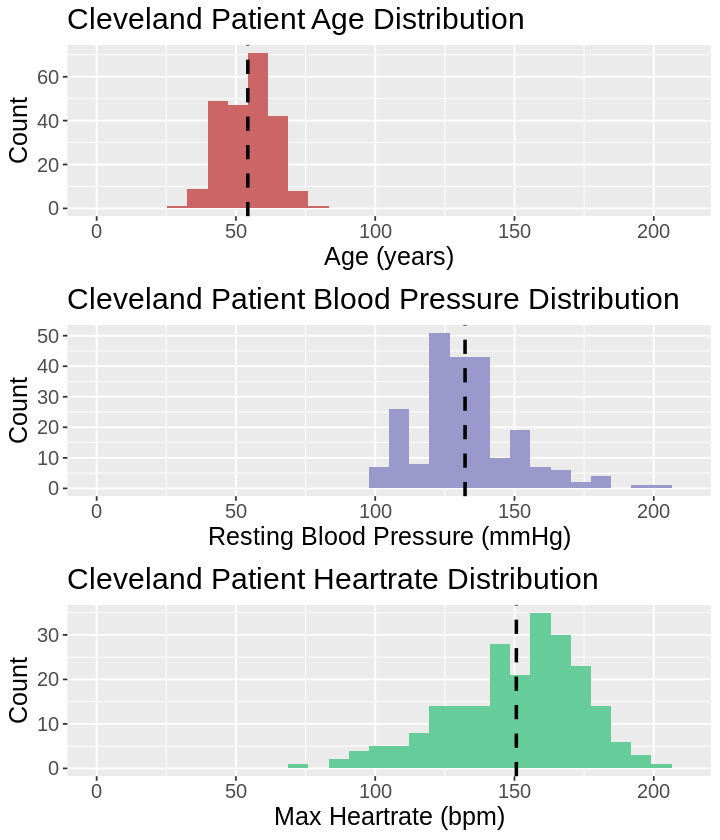

In [17]:
options(repr.plot.length = 15, repr.plot.width = 6)

age_hist <- heart_train %>%
    ggplot(aes(x = age)) +
    geom_histogram(fill = "#CC6666") +
    geom_vline(xintercept = 54.26316, linetype = "dashed", size = 1) +
    labs(x = "Age (years)", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(0, 210) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Cleveland Patient Age Distribution")

bp_hist <- heart_train %>%
    ggplot(aes(x = resting_bp)) +
    geom_histogram(fill = "#9999CC") +
    geom_vline(xintercept = 132.25, linetype = "dashed", size = 1) +
    labs(x = "Resting Blood Pressure (mmHg)", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(0, 210) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Cleveland Patient Blood Pressure Distribution")

hr_hist <- heart_train %>%
    ggplot(aes(x = heartrate_max)) +
    geom_histogram(fill = "#66CC99") +
    geom_vline(xintercept = 150.6623, linetype = "dashed", size = 1) +
    labs(x = "Max Heartrate (bpm)", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(0, 210) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Cleveland Patient Heartrate Distribution")

plot_grid(age_hist, bp_hist, hr_hist, ncol = 1)

### C) Methods:

Firstly, we will need to do preprocessing on our training dataset. We can see from the exploratory analysis that the means and distributions of our predictors are fairly similar, but to optimize our accuracy we will need to standardize them. We still want to explore the relationships between our predictors a bit more before we make our final decision, however, at the moment we intend to compare age and maximum heart rate on a graph to visualize any trends. Next, we will use the disease status column to colour our scatterplot and determine if there is any notable segregation. Ideally, there will be some clear segregation/ trend of points at this stage of the evaluation. 

Next, we must perform cross-validation on our training data to determine the optimal value for K which we will use on our testing set to determine the accuracy of our K – nearest neighbours assessment.

We have included an example of what our early analysis will look like. However, the preprocessing has not occurred yet so it is not complete.

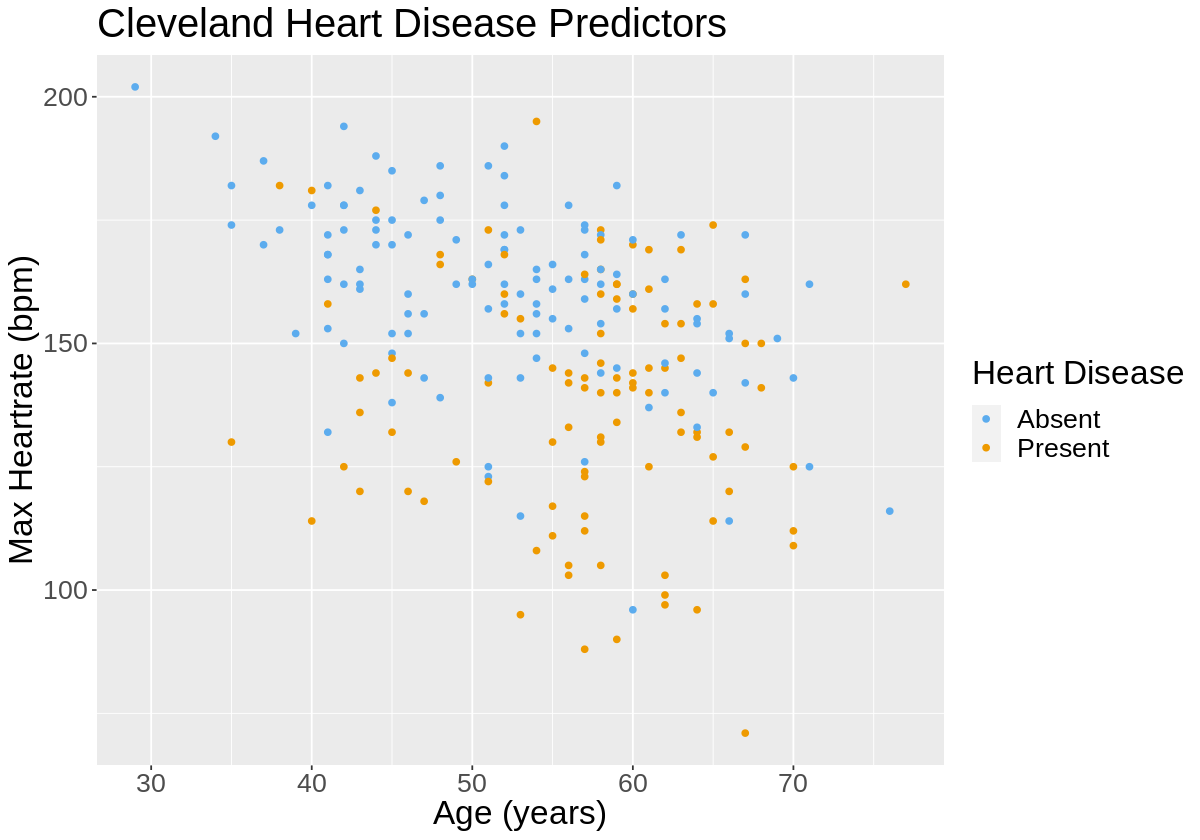

In [18]:
options(repr.plot.length = 10, repr.plot.width = 10)
heart_plot <- heart_train %>%
    ggplot(aes(x = age, 
               y = heartrate_max, 
               colour = disease_status)) +
    geom_point() +
    labs(x = "Age (years)", 
         y = "Max Heartrate (bpm)", 
         colour = "Heart Disease") +
    theme(text = element_text(size=20)) + 
    scale_fill_brewer(palette = "Set1") +
    scale_color_manual(labels = c("Absent", "Present"), 
                       values = c("steelblue2", "orange2")) +
    ggtitle("Cleveland Heart Disease Predictors")
                       
heart_plot

### D) Significance:
        
We believe that our analysis and visualizations will be able to provide a decent estimation for whether or not someone coming into the hospital in Cleveland for heart issues is likely to have advanced heart disease. By comparing new hospital admissions to our analysis, doctors could have an early indication of their disease status. This could lead doctors to make more informed decisions regarding patient care and improve treatments and prognosis. If this analysis proves to be accurate, it would likely lead to the examination of other possible predictors for heart disease, and other diseases. It has the potential to significantly improve patient care in Cleveland.

### E) Appendix


#### References:

Ornish, D., Brown, B.E., Billings, J.H., Scherwitz, L.W., Armstrong, W.T., Ports, T.A., McLanahan, S.M., Kirkeeide, R.L, Gould, K.l. and Brand, R.J. (1990). Can lifestyle changes reverse coronary heart disease?: The Lifestyle Heart Trial. The Lancet, 336(8708), 129-133. https://doi.org/10.1016/0140-6736(90)91656-U.

#### Complete attribute documentation:

* X1 age: age in years
* X2 sex: sex (1 = male; 0 = female)
* X3 chest_pain_type:
-- Value 1: typical angina
-- Value 2: atypical angina
-- Value 3: non-anginal pain
-- Value 4: asymptomatic
* X4 resting_bp: resting blood pressure (in mm Hg on admission to the hospital)
* X5 cholesterol: serum cholesterol in mg/dl
* X6 fasting_bs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* X7 resting_ecg: resting electrocardiographic results
-- Value 0: normal
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* X8 heartrate_max: maximum heart rate achieved
* X9 exang: exercise induced angina (1 = yes; 0 = no)
* X10 oldpeak = ST depression induced by exercise relative to rest
* X11 slope: the slope of the peak exercise ST segment
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping
* X12 ca: number of major vessels (0-3) colored by flourosopy
* X13 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
* X14 disease_status: diagnosis of heart disease (angiographic disease status)
-- Value 0: < 50% diameter narrowing
-- Value 1: > 50% diameter narrowing